In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Config & import

In [155]:
features = ['duration',
 'spectral_bandwidth_kurtosis_01',
 'spectral_bandwidth_max_01',
 'spectral_bandwidth_mean_01',
 'spectral_bandwidth_median_01',
 'spectral_bandwidth_min_01',
 'spectral_bandwidth_skew_01',
 'spectral_bandwidth_std_01',
 'spectral_centroid_kurtosis_01',
 'spectral_centroid_max_01',
 'spectral_centroid_mean_01',
 'spectral_centroid_median_01',
 'spectral_centroid_min_01',
 'spectral_centroid_skew_01',
 'spectral_centroid_std_01',
 'spectral_rolloff_kurtosis_01',
 'spectral_rolloff_max_01',
 'spectral_rolloff_mean_01',
 'spectral_rolloff_median_01',
 'spectral_rolloff_min_01',
 'spectral_rolloff_skew_01',
 'spectral_rolloff_std_01',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'speechiness',
 'tempo',
 'valence']

TARGET_COL = 'genre_title'


In [156]:
test_data = pd.read_csv('../DataBase/processed/test_data.csv')
train_data = pd.read_csv('../DataBase/processed/train_data.csv')

In [157]:
genre_labels = ['Hip-Hop', 'Rock', 'Electronic', 'Pop', 'International',
       'Experimental', 'Blues', 'Jazz', 'Folk', 'Country', 'Spoken',
       'Classical', 'Instrumental', 'Old-Time / Historic', 'Soul-RnB',
       'Easy Listening']
genre_labels_encoded = [k for k in range(12)]

# Label encoding

In [158]:
le = LabelEncoder()
train_data[TARGET_COL] = le.fit_transform(train_data[TARGET_COL])

mapping = dict(zip(le.classes_, np.arange(len(le.classes_))))
print(mapping)

{'Blues': np.int64(0), 'Classical': np.int64(1), 'Electronic': np.int64(2), 'Experimental': np.int64(3), 'Folk': np.int64(4), 'Hip-Hop': np.int64(5), 'Instrumental': np.int64(6), 'International': np.int64(7), 'Jazz': np.int64(8), 'Old-Time / Historic': np.int64(9), 'Pop': np.int64(10), 'Rock': np.int64(11)}


In [159]:
le = LabelEncoder()
test_data[TARGET_COL] = le.fit_transform(test_data[TARGET_COL])

mapping = dict(zip(le.classes_, np.arange(len(le.classes_))))
print(mapping)

{'Blues': np.int64(0), 'Classical': np.int64(1), 'Electronic': np.int64(2), 'Experimental': np.int64(3), 'Folk': np.int64(4), 'Hip-Hop': np.int64(5), 'Instrumental': np.int64(6), 'International': np.int64(7), 'Jazz': np.int64(8), 'Old-Time / Historic': np.int64(9), 'Pop': np.int64(10), 'Rock': np.int64(11)}


# Poids

In [160]:

with open("../DataBase/processed/class_weights.json", "r") as f:
    weights = json.load(f)
weights_encoded = {}

for genre, weight in weights.items():
    if genre in mapping :
        encoded = int(mapping[genre])
        weights_encoded[encoded] = weight
print(weights)
print(weights_encoded)

{'Blues': 35.31091772151899, 'Classical': 2.470825952170062, 'Country': 17.113880368098158, 'Easy Listening': 116.23177083333333, 'Electronic': 0.31811637586954045, 'Experimental': 0.28605029737489746, 'Folk': 1.1745526315789474, 'Hip-Hop': 0.8367014097180564, 'Instrumental': 1.3926922116824763, 'International': 2.2209892515923566, 'Jazz': 5.76355888429752, 'Old-Time / Historic': 5.681390020366599, 'Pop': 1.2481263982102908, 'Rock': 0.23082850641290856, 'Soul-RnB': 21.294370229007633, 'Spoken': 8.636416408668731}
{0: 35.31091772151899, 1: 2.470825952170062, 2: 0.31811637586954045, 3: 0.28605029737489746, 4: 1.1745526315789474, 5: 0.8367014097180564, 6: 1.3926922116824763, 7: 2.2209892515923566, 8: 5.76355888429752, 9: 5.681390020366599, 10: 1.2481263982102908, 11: 0.23082850641290856}


In [161]:
X_train, y_train, X_test, y_test = train_data[features], train_data[TARGET_COL], test_data[features], test_data[TARGET_COL]
sample_weight = y_train.map(weights_encoded)

# Training & predictions

## Random forest

In [162]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train, sample_weight=sample_weight)
predictions = random_forest.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.81      0.78      0.79        37
           2       0.70      0.74      0.72       364
           3       1.00      0.33      0.50         3
           4       0.59      0.42      0.49       106
           5       0.81      0.65      0.72       156
           6       0.00      0.00      0.00        24
           7       1.00      0.19      0.32        16
           8       0.71      0.12      0.21        40
           9       0.98      0.95      0.97        65
          10       0.50      0.02      0.03        56
          11       0.66      0.89      0.76       500

    accuracy                           0.70      1374
   macro avg       0.73      0.44      0.48      1374
weighted avg       0.69      0.70      0.67      1374



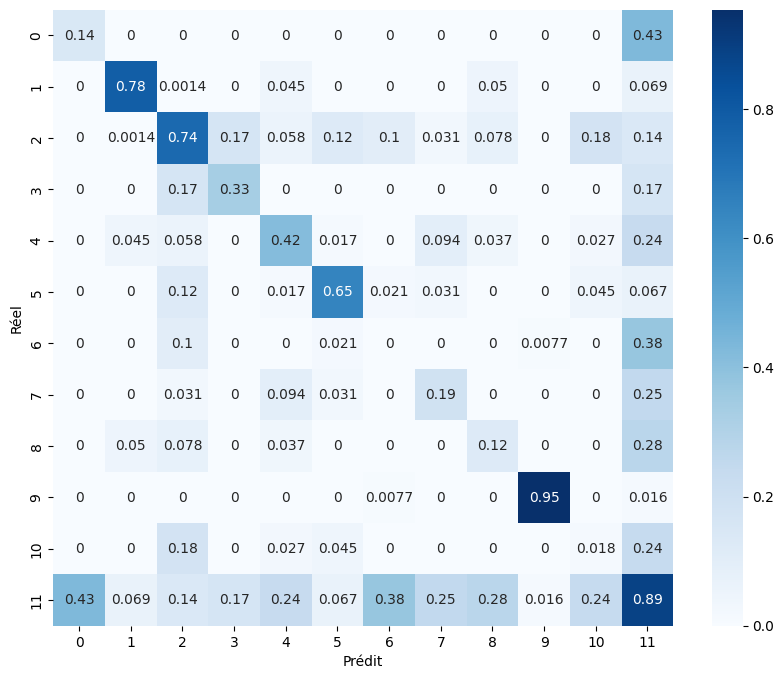

In [163]:
cm = confusion_matrix(y_test, predictions, labels=genre_labels_encoded)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
similarity = (cm_norm + cm_norm.T) / 2
plt.figure(figsize=(10,8))
sns.heatmap(similarity, annot=True, cmap="Blues", xticklabels=genre_labels_encoded, yticklabels=genre_labels_encoded)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

## XGBoost

In [164]:
xgb = XGBClassifier(eval_metric="mlogloss")
xgb.fit(X_train, y_train, sample_weight=sample_weight)
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.50      0.29      0.36         7
           1       0.84      0.84      0.84        37
           2       0.72      0.78      0.75       364
           3       0.00      0.00      0.00         3
           4       0.50      0.52      0.51       106
           5       0.76      0.76      0.76       156
           6       0.20      0.04      0.07        24
           7       1.00      0.31      0.48        16
           8       0.62      0.45      0.52        40
           9       0.94      0.95      0.95        65
          10       0.46      0.23      0.31        56
          11       0.75      0.82      0.78       500

    accuracy                           0.73      1374
   macro avg       0.61      0.50      0.53      1374
weighted avg       0.71      0.73      0.71      1374



c:\Users\Lesli\Downloads\anaconda3\envs\env_hackathon\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lesli\Downloads\anaconda3\envs\env_hackathon\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lesli\Downloads\anaconda3\envs\env_hackathon\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

Idée : relier les classes les moins bien représentées/ moins bien prédites avec une proche

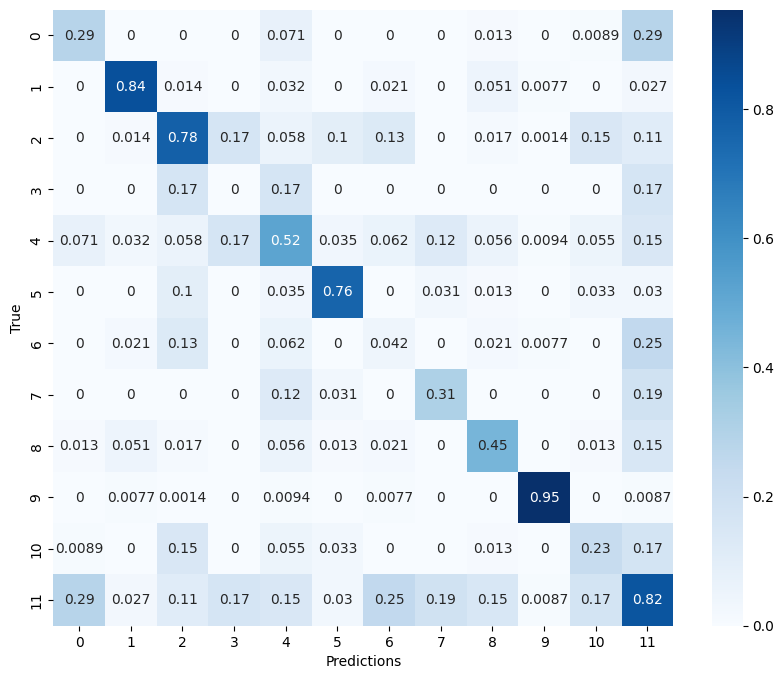

In [165]:
cm = confusion_matrix(y_test, predictions, labels=genre_labels_encoded)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
similarity = (cm_norm + cm_norm.T) / 2
plt.figure(figsize=(10,8))
sns.heatmap(similarity, annot=True, cmap = "Blues", xticklabels=genre_labels_encoded, yticklabels=genre_labels_encoded)
plt.xlabel("Predictions")
plt.ylabel("True")
plt.show()

'Blues': 0, 'Classical': 1, 'Electronic': 2, 'Experimental': 3, 'Folk': 4, 'Hip-Hop': 5, 'Instrumental':  6, 'International': 7, 'Jazz': 8, 'Old-Time / Historic': 9, 'Pop': 10, 'Rock': 11

Il est possible de relier Electronic + Experimental + Pop + Hip-Hop --> Energique
Rock + Blues + Instrumental --> Rock
Classical + Jazz --> Acoustic
OldTime/Historic + Folk + Country + International --> Traditionnal

Idealement on aurait pu garder classical, jazz et hip hop séparés mais pour les besoins du projet on les regroupe avec le groupe le plus proche